In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('all-data.csv',delimiter=",",encoding="latin-1")

In [3]:
df.head(3)

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...


In [4]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [5]:
df.index = np.arange(df.shape[0])
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

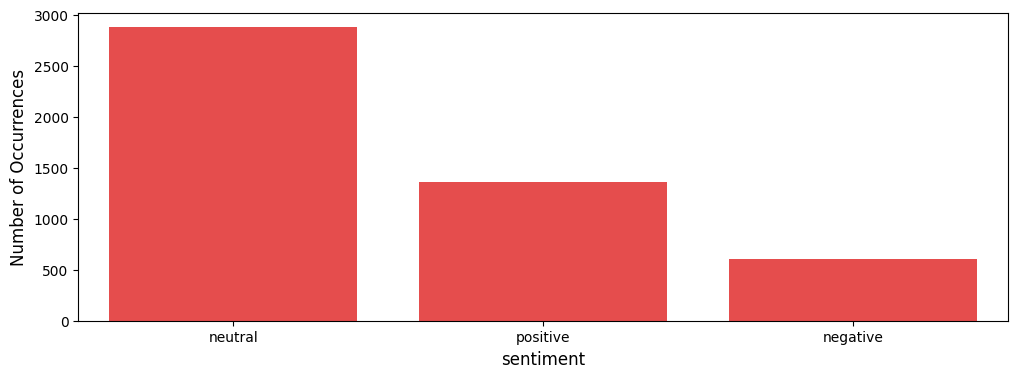

In [6]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro, alpha=0.8,color="red")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.show();

In [7]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4845 entries, 0 to 4844
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4845 non-null   int64 
 1   Message    4845 non-null   object
dtypes: int64(1), object(1)
memory usage: 113.6+ KB


In [9]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(1000)

Amer Sports divests an industrial site in Rumilly , France -  This announcement is distributed by Thomson Reuters on behalf of Thomson Reuters clients .
Message: 1


In [10]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-10-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [11]:
df.head(100)

,sentiment,Message
0,1,technopolis plans to develop in stages an area...
1,2,the international electronic industry company ...
2,0,with the new production plant the company woul...
3,0,according to the company 's updated strategy f...
4,0,financing of aspocomp 's growth aspocomp is ag...
...,...,...
95,0,finnish high technology provider vaahto group ...
96,0,net sales of finnish food industry company l+æ...
97,0,an individual promotion also generated slightl...
98,0,biohit already services many current genesis c...


In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Found 4845 unique tokens.


In [13]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0,0,0,0,0,0,0,0,0,0,...,96,746,3,1185,574,4,747,1,928,20
1,0,0,0,0,0,0,0,0,0,0,...,1,5009,2,15,267,972,1,876,5010,250
2,0,0,0,0,0,0,0,0,0,0,...,211,2,685,525,4,1640,115,1,88,1186
3,0,0,0,0,0,0,0,0,0,0,...,39,42,31,507,2,84,150,2,28,27
4,0,0,0,0,0,0,0,0,0,0,...,1504,14,3501,116,1842,5013,1505,1188,1843,2795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,0,0,0,0,0,0,0,0,0,0,...,1552,3494,5,3292,10106,4458,7,1,1515,292
4841,0,0,0,0,0,0,0,0,0,0,...,18,54,60,85,396,5,36,728,29,1525
4842,0,0,0,0,0,0,0,0,0,0,...,52,187,1375,27,1080,2,8,129,38,23
4843,0,0,0,0,0,0,0,0,0,0,...,5,8,58,46,23,13,8,57,54,23


In [14]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [15]:
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

In [16]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 1132067.12it/s]


In [17]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 1299552.81it/s]


CPU times: user 12.8 s, sys: 110 ms, total: 12.9 s
Wall time: 13.2 s


In [18]:
d2v_model.wv.most_similar(positive=['profit'], topn=100)

[('loss', 0.7029241919517517),
 ('trojan', 0.5253889560699463),
 ('digitally', 0.4893586039543152),
 ('profits', 0.4881073236465454),
 ('january-june', 0.47891658544540405),
 ('chopra', 0.47281017899513245),
 ('break-even', 0.4695354402065277),
 ('13.9', 0.46860775351524353),
 ('mmo1v', 0.46684297919273376),
 ('koduetra', 0.4646110534667969),
 ('atul', 0.4585469961166382),
 ('58.7', 0.45578357577323914),
 ('income', 0.453758180141449),
 ('wwd', 0.4479103684425354),
 ('activities', 0.4455413222312927),
 ('eur121m', 0.4422265589237213),
 ('56.5', 0.4411512315273285),
 ('241.8', 0.44030532240867615),
 ('bill', 0.4245903193950653),
 ('testing', 0.4209177494049072),
 ('44.5', 0.420736163854599),
 ('.9', 0.4170055389404297),
 ('virpi', 0.4097869396209717),
 ('4.9', 0.4089290499687195),
 ('result', 0.4054117202758789),
 ('68.3', 0.40535902976989746),
 ('walby', 0.40535813570022583),
 ('803.6', 0.4036749601364136),
 ('201', 0.40303125977516174),
 ('two-car', 0.40169093012809753),
 ('turnover',

In [19]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('property', 0.46088287234306335),
 ('estate', 0.4355722963809967),
 ('ethibel', 0.4308726489543915),
 ('i.', 0.4198230803012848),
 ('fund', 0.4008817672729492),
 ('lem1s', 0.4007147550582886),
 ('ebit', 0.39643988013267517),
 ('zao', 0.38826698064804077),
 ('real', 0.3848518133163452),
 ('register', 0.3816128075122833)]

In [20]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9489843845367432),
 ('143.9', 0.7645471096038818),
 ('oyname', 0.7373504042625427),
 ('mika', 0.7250294089317322),
 ('mammila', 0.710792064666748),
 ('baby', 0.7100358605384827),
 ('aptly', 0.707196056842804),
 ('apac', 0.7045401334762573),
 ('tuomo', 0.7031421661376953),
 ('3.81', 0.692901074886322)]

In [63]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def tsne_plot(model):
    labels = []
    tokens = []

    # Utilisation de `index_to_key` au lieu de `vocab`
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    # Conversion de la liste `tokens` en un tableau NumPy
    tokens = np.array(tokens)

    # Application de TSNE
    tsne_model = TSNE(n_components=2, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.show()


In [ ]:
tsne_plot(d2v_model)

KeyboardInterrupt: 

In [21]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding

In [24]:
model = Sequential()

# Utiliser index_to_key à la place de vocab
vocab_size = len(d2v_model.wv.index_to_key)

# Ajouter l'Embedding Layer
model.add(Embedding(vocab_size + 1, 20, input_length=X.shape[1], trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [27]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 6s - 43ms/step - acc: 0.5947 - loss: 0.5607
Epoch 2/50
129/129 - 4s - 29ms/step - acc: 0.6666 - loss: 0.4626
Epoch 3/50
129/129 - 5s - 37ms/step - acc: 0.7715 - loss: 0.3377
Epoch 4/50
129/129 - 4s - 34ms/step - acc: 0.8213 - loss: 0.2607
Epoch 5/50
129/129 - 6s - 50ms/step - acc: 0.8662 - loss: 0.2031
Epoch 6/50
129/129 - 3s - 21ms/step - acc: 0.9274 - loss: 0.1381
Epoch 7/50
129/129 - 5s - 39ms/step - acc: 0.9570 - loss: 0.0915
Epoch 8/50
129/129 - 6s - 46ms/step - acc: 0.9721 - loss: 0.0654
Epoch 9/50
129/129 - 3s - 21ms/step - acc: 0.9781 - loss: 0.0510
Epoch 10/50
129/129 - 5s - 39ms/step - acc: 0.9832 - loss: 0.0406
Epoch 11/50
129/129 - 5s - 41ms/step - acc: 0.9879 - loss: 0.0330
Epoch 12/50
129/129 - 5s - 38ms/step - acc: 0.9891 - loss: 0.0317
Epoch 13/50
129/129 - 3s - 22ms/step - acc: 0.9913 - loss: 0.0244
Epoch 14/50
129/129 - 4s - 33ms/step - acc: 0.9937 - loss: 0.0196
Epoch 15/50
129/129 - 3s - 27ms/step - acc: 0.9891 - loss: 0.0238
Epoch 16/50
129/129

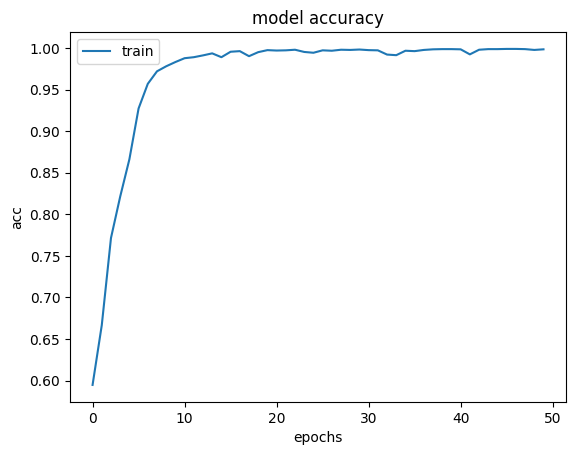

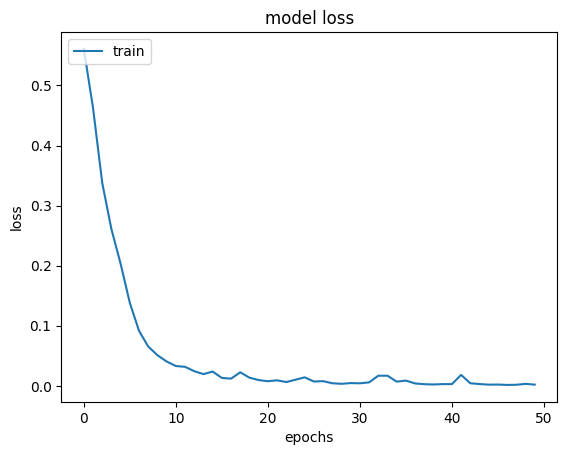

<Figure size 640x480 with 0 Axes>

In [28]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [29]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 2s - 13ms/step - acc: 0.9993 - loss: 0.0013
23/23 - 0s - 8ms/step - acc: 0.7029 - loss: 1.2998
Train: 0.999, Test: 0.7029


In [36]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)


[[3.5744627e-08 9.9999994e-01 1.3704399e-08]
 [9.9999887e-01 5.6404423e-07 5.1733355e-07]
 [2.4737556e-10 9.9999994e-01 3.1190667e-10]
 ...
 [9.7963709e-01 1.1194317e-02 9.1684982e-03]
 [2.6444644e-09 1.0000000e+00 1.8343752e-09]
 [9.9998760e-01 3.7994701e-06 8.6187993e-06]]


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [38]:
yhat_classes = yhat_classes[:, 1]

In [33]:
import numpy as np
rounded_labels = np.argmax(Y_test,axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

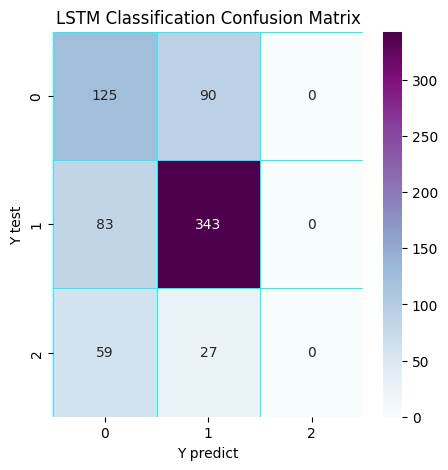

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [41]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7303 - loss: 1.3434
score: 1.42
acc: 0.70


In [42]:
model.save('Mymodel.h5')


In [43]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[[0.34813228 0.06833831 0.5835294 ]] 2


In [44]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
[[9.9998951e-01 1.8205003e-06 8.7133858e-06]] 0


In [45]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[4.3222897e-11 1.0000000e+00 6.7457637e-11]] 1


In [46]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[9.9999630e-01 3.2134403e-06 4.8703811e-07]] 0


In [47]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[7.1066003e-10 1.0000000e+00 4.4453904e-10]] 1


In [48]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[5.2324708e-07 3.8643245e-07 9.9999905e-01]] 2
